## 🎬 Movie Recommendation System using SARSA


### 🧠 Objectives :
Build an intelligent recommendation system that learns to suggest the most relevant content to users by analysing their interactions (clicks, time spent, etc.). The system uses the reinforcement learning algorithm SARSA (State-Action-Reward-State-Action) to learn an optimised recommendation policy.



#### Labraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [3]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [4]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
48446,313,2528,4.0,1030474877,Logan's Run (1976),Action|Adventure|Sci-Fi
43903,292,103141,3.5,1385677324,Monsters University (2013),Adventure|Animation|Comedy
67928,438,4776,3.0,1105668497,Training Day (2001),Crime|Drama|Thriller
3676,22,2300,4.0,1268330627,"Producers, The (1968)",Comedy
77096,482,50,4.0,1105396885,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
42788,288,3507,3.5,1079984124,"Odd Couple, The (1968)",Comedy
74601,474,6377,4.0,1070397403,Finding Nemo (2003),Adventure|Animation|Children|Comedy
98111,606,5943,3.0,1173047850,Maid in Manhattan (2002),Comedy|Romance
2728,19,2374,2.0,965707518,Gung Ho (1986),Comedy|Drama
19113,122,122900,4.0,1461561662,Ant-Man (2015),Action|Adventure|Sci-Fi


In [5]:
## 1. Analyse Exploratoire
print("=== Informations de base ===")
print(df.info())

=== Informations de base ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100835 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB
None


In [6]:
print("\n=== Valeurs manquantes ===")
print(df.isnull().sum())


=== Valeurs manquantes ===
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       1
dtype: int64


In [7]:
# Analyse des statistiques de base
print(f"Nombre total de notations: {len(df)}")
print(f"Nombre d'utilisateurs uniques: {df['userId'].nunique()}")
print(f"Nombre de films uniques: {df['movieId'].nunique()}")
print(f"Note moyenne: {df['rating'].mean():.2f}")

Nombre total de notations: 100836
Nombre d'utilisateurs uniques: 610
Nombre de films uniques: 9724
Note moyenne: 3.50


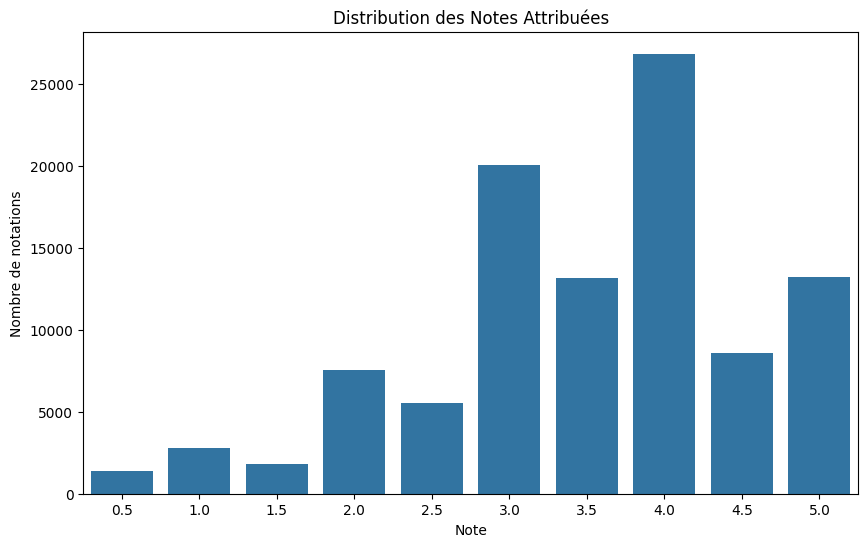

In [8]:
# Distribution des notes
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribution des Notes Attribuées')
plt.xlabel('Note')
plt.ylabel('Nombre de notations')
plt.show()

C:\Users\Yoga\AppData\Local\Temp\ipykernel_6376\3256705447.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')


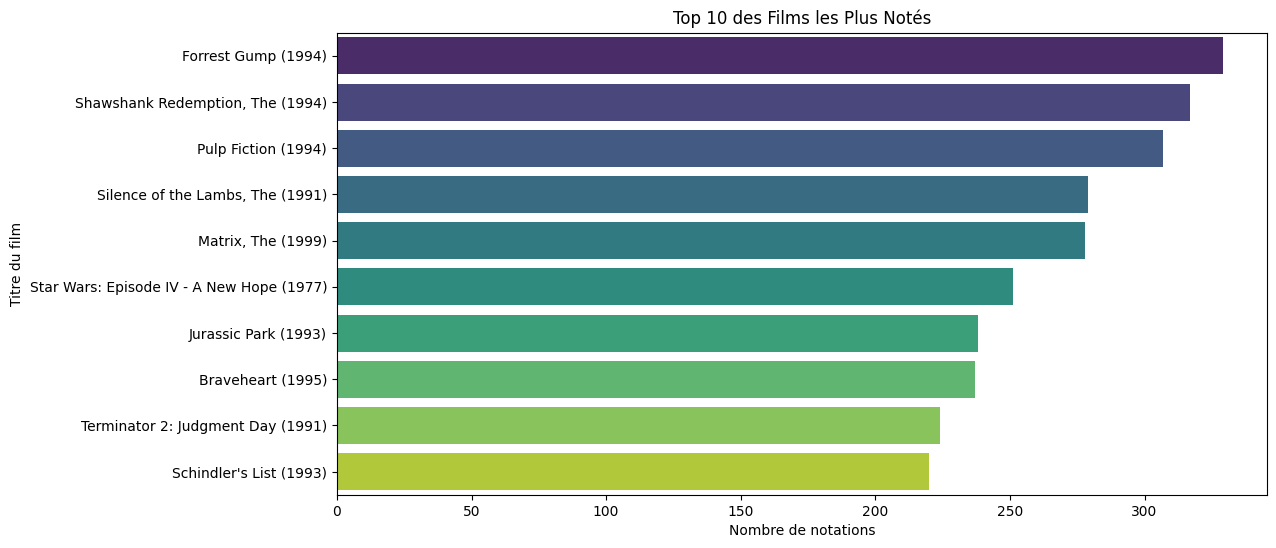

In [9]:
top_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')
plt.title('Top 10 des Films les Plus Notés')
plt.xlabel('Nombre de notations')
plt.ylabel('Titre du film')
plt.show()

C:\Users\Yoga\AppData\Local\Temp\ipykernel_6376\3935912188.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y=movie_stats.index, data=movie_stats, palette='magma')


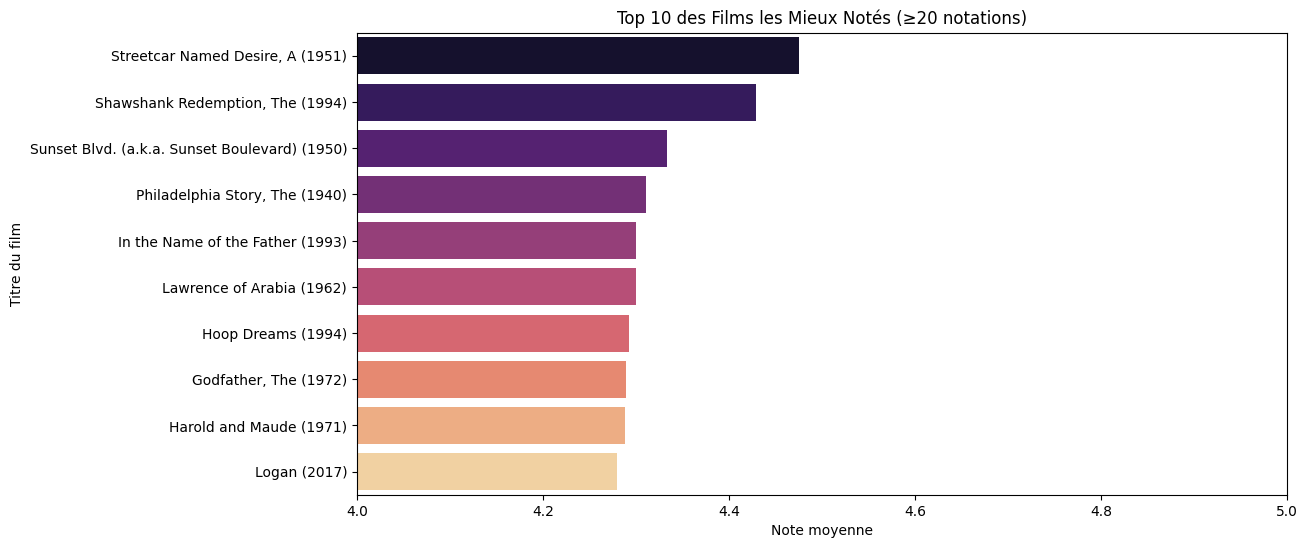

In [10]:
movie_stats = df.groupby('title').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).query('num_ratings >= 20').sort_values('avg_rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y=movie_stats.index, data=movie_stats, palette='magma')
plt.title('Top 10 des Films les Mieux Notés (≥20 notations)')
plt.xlabel('Note moyenne')
plt.ylabel('Titre du film')
plt.xlim(4, 5)
plt.show()

In [11]:
top_users = df['userId'].value_counts().head(40).index.tolist()
top_movies = df['movieId'].value_counts().head(100).index.tolist()
df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)]

#### Re-indexing


**=> userId for Q-Table rows** 

**=> movieId for Q-Table columns** 

**=> idx_to_movie when argmax(Q[“state”]) is extracted to translate the index into a real movieId**.

In [12]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [13]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

In [14]:
n_users, n_movies

(40, 100)

#### Extract all possible movie genres


In [15]:
genre_set = set()
for g in df['genres']:
    if isinstance(g, str):
        genre_set.update(g.split('|'))
        
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Genre coding for each film

In [16]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [17]:
movie_genre_vectors = {mid: encoder_genres(genre_str) if isinstance(genre_str, str) else np.zeros(len(all_genres)) for mid, genre_str in movie_genres.items()}


#### Q-table


In [18]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [19]:
def choisir_action(user_idx):
    if np.random.rand() < epsilon:
        return np.random.randint(n_movies)
    else:
        return np.argmax(q_table[user_idx])

#### Get a user's favorite genres



In [20]:

def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array([movie_genre_vectors[mid] for mid in liked['movieId'] if mid in movie_genre_vectors])
    return vectors.mean(axis=0)

#### genre affinity awards



In [21]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### SARSA training



In [22]:
for ep in tqdm(range(episodes), desc="Training"):
    for user_idx in range(n_users):
        user_id = list(user_to_idx.keys())[user_idx]
        seen_movies = df[df['userId'] == user_id]['movieId'].map(movie_to_idx).dropna().astype(int).tolist()
        
        movie_idx = choisir_action(user_idx)
        for step in range(max_steps):
            next_movie_idx = choisir_action(user_idx)
            
            r = obtenir_recompense(user_idx, movie_idx)
            q_current = q_table[user_idx, movie_idx]
            q_next = q_table[user_idx, next_movie_idx]

            q_table[user_idx, movie_idx] += alpha * (r + gamma * q_next - q_current)

            movie_idx = next_movie_idx


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training: 100%|██████████| 500/500 [15:06<00:00,  1.81s/it]


#### Plot training curve


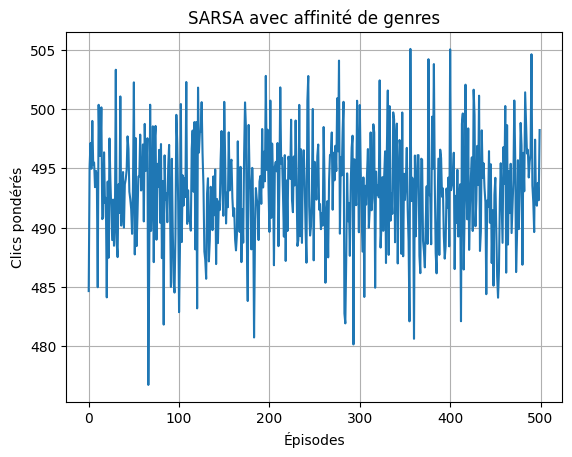

In [125]:
plt.plot(clics_par_episode)
plt.title("SARSA avec affinité de genres")
plt.xlabel("Épisodes")
plt.ylabel("Clics pondérés")
plt.grid()
plt.show()


#### Recommend N unseen movies to a user


In [126]:
def recommander_films(user_id, N=5):
    user_idx = user_to_idx[user_id]
    seen_movies = set(df[df['userId'] == user_id]['movieId'])
    unseen_movie_indices = [idx for idx in range(n_movies) if idx_to_movie[idx] not in seen_movies]
    q_values = [(idx, q_table[user_idx, idx]) for idx in unseen_movie_indices]
    top_q = sorted(q_values, key=lambda x: x[1], reverse=True)[:N]
    return [(idx_to_movie[idx], idx_to_title[idx_to_movie[idx]], q) for idx, q in top_q]


#### Generate recommendations for all users and save to CSV


In [130]:
recommendations = []

for user_id in tqdm(user_to_idx.keys(), desc="Generating recommendations"):
    recs = recommander_films(user_id, N=5)
    for movie_id, title, score in recs:
        genres = movie_genres.get(movie_id, "")
        recommendations.append({
            'userId': user_id,
            'movieId': movie_id,
            'title': title,
            'recommanded_genres': genres,
            'Q_value': round(score, 4)
        })

recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv("data/recommendations_sarsa_1.csv", index=False)
print("✅ Recommendations saved to data/recommendations_sarsa_1.csv")


Generating recommendations: 100%|██████████| 40/40 [00:00<00:00, 199.84it/s]

✅ Recommendations saved to data/recommendations_sarsa_1.csv


In [131]:
df_reco1 = pd.read_csv("data/recommendations_sarsa_1.csv")

In [132]:
df_reco1.head(20)

,userId,movieId,title,recommanded_genres,Q_value
0,19,5989,Catch Me If You Can (2002),Crime|Drama,5.2313
1,19,1036,Die Hard (1988),Action|Crime|Thriller,5.1895
2,19,608,Fargo (1996),Comedy|Crime|Drama|Thriller,5.1417
3,19,110,Braveheart (1995),Action|Drama|War,4.9943
4,19,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.7689
5,28,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.3314
6,28,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,1.5481
7,28,34,Babe (1995),Children|Drama,1.2765
8,28,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,1.2066
9,28,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.1916
